In [19]:
import liionpack as lp
import pybamm
import os
from lcapy import Circuit
import numpy as np

os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

In [18]:
Np=2
Rp=1e-5
Ri=1e-5
Rs=1e-5
netlist = lp.setup_circuit(Np=Np, Ns=1, Rc=Rs, Rt=Rp, Ri=Ri, Rb=Rp)
netlist

,desc,node1,node2,value,node1_x,node1_y,node2_x,node2_y
0,Rbn1,1,2,0.00001,0,0,1,0
1,Rc0,3,1,0.00001,0,1,0,0
2,V0,5,3,4.20000,0,2,0,1
3,Ri0,7,5,0.00001,0,3,0,2
4,Rc1,4,2,0.00001,1,1,1,0
5,V1,6,4,4.20000,1,2,1,1
6,Ri1,8,6,0.00001,1,3,1,2
7,Rbp1,7,8,0.00001,0,3,1,3
8,Rtp1,7,9,0.00001,0,3,-1,3
9,I0,9,0,80.00000,-1,3,-1,0


In [20]:
setup_circuit_v2()

,desc,node1,node2,value,node1_x,node1_y,node2_x,node2_y
0,Rpn1,1,2,0.00001,0,0,1,0
1,Rs0,3,1,0.00001,0,1,0,0
2,V0,5,3,4.20000,0,2,0,1
3,Ri0,7,5,0.00001,0,3,0,2
4,Rs1,4,2,0.00001,1,1,1,0
5,V1,6,4,4.20000,1,2,1,1
6,Ri1,8,6,0.00001,1,3,1,2
7,Rpp1,7,8,0.00001,0,3,1,3
8,Rpp0,7,9,0.00001,0,3,-1,3
9,I0,9,0,5.00000,-1,3,-1,0


In [38]:
## Circuit Setup
def setup_circuit_v2(Np=2, Rp=1e-5, Ri=1e-5, Rs=1e-5, I=5):
    #Np=2, Rp=1e-5, Ri=1e-5, Rs=1e-5
    netlist = lp.setup_circuit(Np=Np, Ns=1, Rc=Rs, Rt=Rp, Ri=Ri, Rb=Rp, I=I)
    descs = netlist["desc"].values
    for index, desc in enumerate(descs):
        if desc == "Rtn1":
            descs[index] = "Rpn0"
        elif desc == "Rtp1":
            descs[index] = "Rpp0"
        else:
            descs[index] = desc.replace("Rc", "Rs").replace("Rb", "Rp")
    netlist["desc"] = descs
    return netlist

def make_lcapy_circuit_v2(netlist):
    """
    Generate a circuit that can be used with lcapy

    Args:
        netlist (pandas.DataFrame):
            A netlist of circuit elements with format. desc, node1, node2, value.

    Returns:
        lcapy.Circuit:
            The Circuit class is used for describing networks using netlists.
            Despite the name, it does not require a closed path.

    """
    cct = Circuit()
    I_map = netlist["desc"].str.find("I") > -1
    net2 = netlist.copy()
    net2.loc[I_map, ("node1")] = netlist["node2"][I_map]
    net2.loc[I_map, ("node2")] = netlist["node1"][I_map]
    d1 = "down"
    d2 = "up"
    I_xs = [net2[I_map]["node1_x"].values[0], net2[I_map]["node2_x"].values[0]]
    I_left = np.any(np.array(I_xs) == -1)
    all_desc = netlist["desc"].values
    for index, row in net2.iterrows():
        color = "white"
        desc, n1, n2, value, n1x, n1y, n2x, n2y = row[:8]
        if desc[0] == "V":
            direction = d1
        elif desc[0] == "I":
            direction = d2
        elif desc[0] == "R":
            if desc[1] == "p":
                if desc[3] != "0":
                    direction = "right"
                else:
                    # The reistors have the 1 suffix
                    # Convert the value to the total reistance if a wire element
                    # is in the netlist
                    w_desc = desc[:3] + "0"
                    if w_desc in all_desc:
                        value *= 1
                    desc = desc
                    # Terminal loop is C shaped with positive at the top so
                    # order is left-vertical-right if we're on the left side
                    # and right-vertical-left if we're on the right side
                    if desc[2] == "p":
                        if I_left:
                            direction = "left"
                            # if the terminal connection is not at the end then
                            # extend the element connections
                            if n1x > 0:
                                direction += "=" + str(1 + n1x)
                        else:
                            direction = "right"
                            if n1x < I_xs[0] - 1:
                                direction += "=" + str(1 + I_xs[0] - n1x)
                    else:
                        if I_left:
                            direction = "right"
                        else:
                            direction = "left"
            else:
                direction = d1
        if desc == "W":
            string = desc + " " + str(n1) + " " + str(n2)
        else:
            string = desc + " " + str(n1) + " " + str(n2) + " " + str(value)
        string = string + "; " + direction
        string = string + ", color=" + color
        cct.add(string)
    # Add ground node
    cct.add("W 0 00; down, sground, color={}".format(color))
    return cct

def draw_circuit_v2(
    netlist,
    cpt_size=1.0,
    dpi=300,
    node_spacing=2.0,
    scale=1.0,
    help_lines=0.0,
    font="\scriptsize",
    label_ids=True,
    label_values=True,
    draw_nodes=True,
    label_nodes="primary",
    style="american",
):
    """
    Draw a latex version of netlist circuit
    N.B only works with generated netlists not imported ones.

    Args:
        netlist (pandas.DataFrame):
            A netlist of circuit elements with format. desc, node1, node2, value.
        cpt_size (float):
            component size, default 1.0
        dpi (int):
            dots per inch, default 300
        node_spacing (float):
            spacing between component nodes, default 2.0
        scale (float):
            schematic scale factor, default 1.0
        help_lines (float):
            distance between lines in grid, default 0.0 (disabled)
        font (string):
            LaTex font size, default \scriptsize
        label_ids (bool):
            Show component ids, default True
        label_values (bool):
            Display component values, default True
        draw_nodes (bool):
            True to show all nodes (default), False to show no nodes,'primary' to show
            primary nodes, 'connections' to show nodes that connect more than
            two components, 'all' to show all nodes.
        label_nodes (bool):
            True to label all nodes, False to label no nodes, 'primary' to label
            primary nodes (default), 'alpha' to label nodes starting with a letter,
            'pins' to label nodes that are pins on a chip, 'all' to label all nodes
        style (string):
            'american', 'british', or 'european'

    Example:
        >>> import liionpack as lp
        >>> net = lp.setup_circuit(Np=3, Ns=1, Rb=1e-4, Rc=1e-2, Ri=5e-2, V=3.2, I=80.0)
        >>> lp.draw_circuit(net)
    """
    cct = make_lcapy_circuit_v2(netlist)
    kwargs = {
        "cpt_size": cpt_size,
        "dpi": dpi,
        "node_spacing": node_spacing,
        "scale": scale,
        "help_lines": help_lines,
        "font": font,
        "label_ids": label_ids,
        "label_values": label_values,
        "draw_nodes": draw_nodes,
        "label_nodes": label_nodes,
        "style": style,
    }
    cct.draw(**kwargs)

# Battery Setup


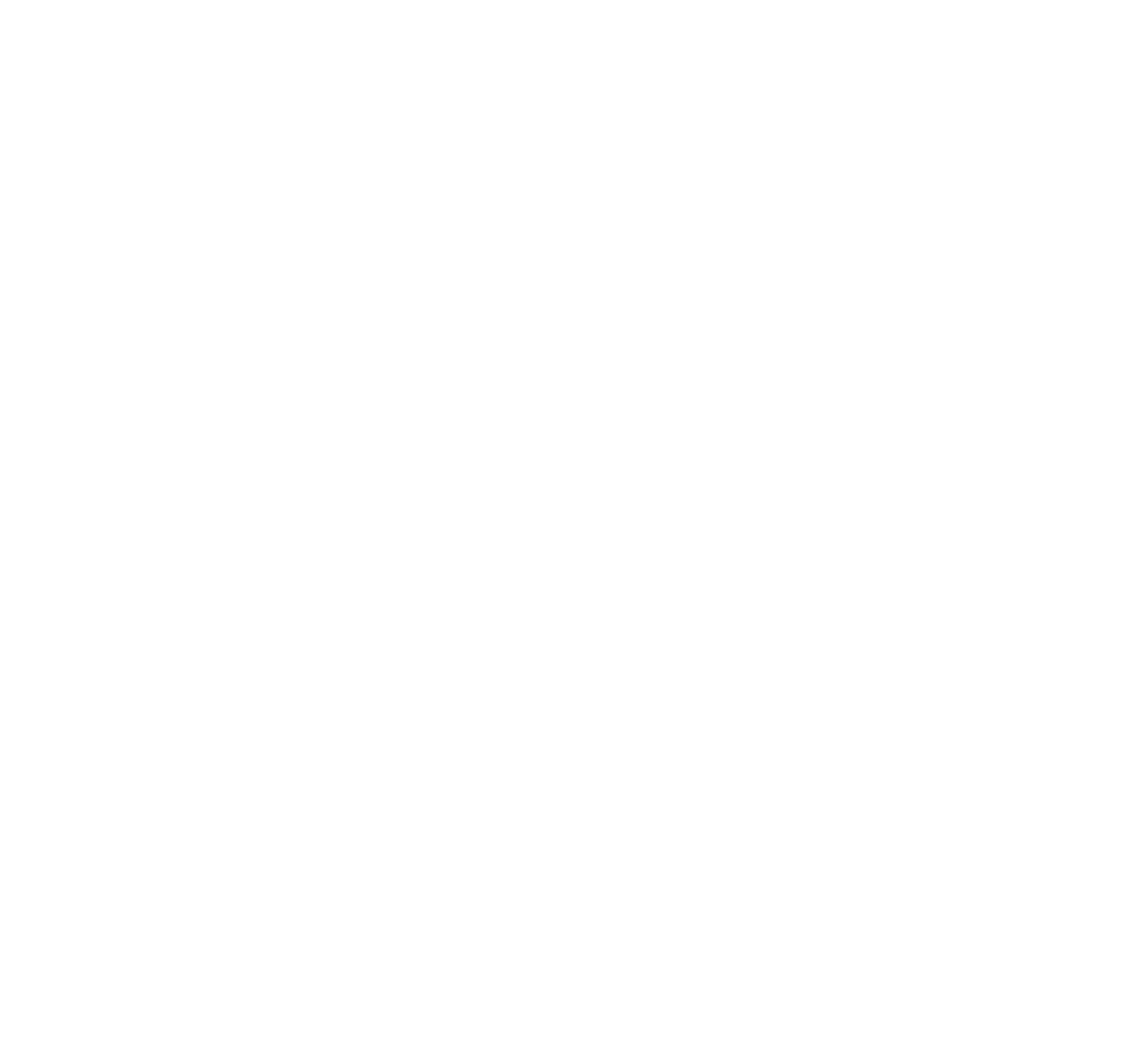